# Convex Image In-painting

Really cool use of convex optimisatoin which 

https://stanford.edu/~boyd/papers/pdf/cvx_opt_intro.pdf

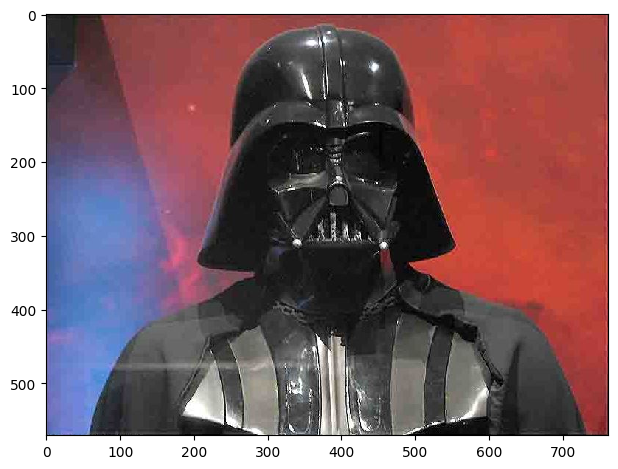

In [1]:
from skimage import io

img = io.imread('vader.png')
io.imshow(img)

# Remove 90% of the information with uniform noise 

In [2]:
img.shape

(571, 762, 3)

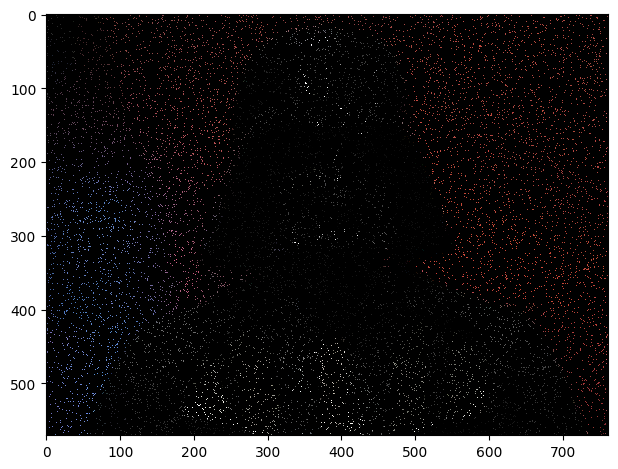

In [3]:
import numpy as np
mask = np.random.uniform(size=(img.shape[0], img.shape[1])) > 0.05
masked_img = img.copy()
masked_img[mask] = 0
io.imshow(masked_img)

Want to minimise the total variatoin in 3 dimensiosn.

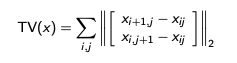

problem = Problem(Minimize(expression), constraints)

In [4]:
import cvxpy as cp 

#p = cp.Parameter()
#I = cp.Variable((571, 762,3))
R = cp.Variable((571, 762))
G = cp.Variable((571, 762))
B = cp.Variable((571, 762))

R.value = img[...,0]
G.value = img[...,1]
B.value = img[...,2]

#solver = cp.SCS() # max_iters=100)
mask_original = img * mask[...,np.newaxis]

total_variation = cp.tv(*[R,G,B])

contraints = [
    cp.multiply(mask, R) == cp.multiply(mask, img[...,0]),
    cp.multiply(mask, G) == cp.multiply(mask, img[...,1]),
    cp.multiply(mask, B) == cp.multiply(mask, img[...,2])
]
problem = cp.Problem(cp.Minimize(total_variation), contraints)
problem.solve(verbose=True,solver=cp.SCS, max_iters=100)
if problem.status not in ["infeasible", "unbounded"]:
    # Otherwise, problem.value is inf or -inf, respectively.
    print("Optimal value: %s" % problem.value)
    for variable in problem.variables():
        print("Variable %s: value %s" % (variable.name(), variable.value))

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 27 01:48:41 PM: Your problem has 1305306 variables, 3 constraints, and 0 parameters.
(CVXPY) May 27 01:48:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 27 01:48:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 27 01:48:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 27 01:48:41 PM: Compiling problem (target solver=SCS).
(CVXPY) May 27 01:48:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

/home/fergus/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# Display reconstruction:

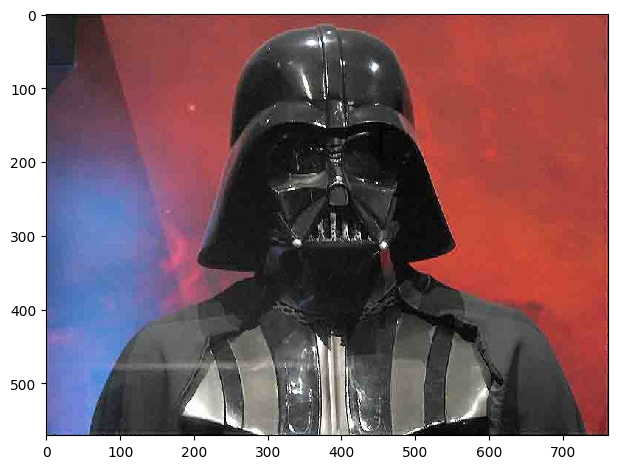

In [5]:
out = np.zeros((571, 762, 3))
for i,X in enumerate([R,G,B]):
    out[...,i] = X.value
out = np.clip(out, 0, 255)
     
io.imshow(out / 255)

# Okay but is it useful. Why not just apply a filter?

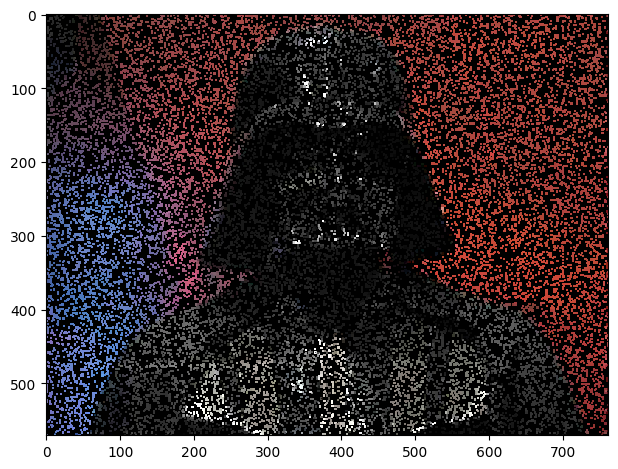

In [12]:
from scipy.ndimage import maximum_filter, median_filter
mf = maximum_filter(masked_img, size=(3,3,1))
mf[mask == 0] = img[mask == 0]
io.imshow(mf)

# Total variation criterion in numpy...

cvxpy has a method for this but would be nice to see how it would work. I know the following code(ish) does a 1D smoothing (y(t+1) = x(t+1) - x(t))
```
x = np.array(...) # 1d array
bidiag = np.diag(len(X)) - np.diag(len(X)-1, 1)
np.dot(bidiag, x.T)
```

In [7]:
# A row-only gresycale total varition criterion: 
 

bidiag = np.diag(np.ones(9), 1) - np.diag(np.ones(10)) 
bidiag

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

In [8]:
x = np.arange(10)
r = np.dot(x, bidiag)
print(x)
print(r)

[0 1 2 3 4 5 6 7 8 9]
[ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
